# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [612]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer

columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = None, names = columns))
fires_dt.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0,0
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18,33,0.9,0,0
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0,0
4,8,6,mar,fri,91.7,33.3,77.5,9,8.3,97,4,0.2,0


# Get X and Y

Create the features data frame and target data.

In [613]:
fires_dt = fires_dt.drop(0).reset_index(drop=True)
numeric_columns = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area']
fires_dt[numeric_columns] = fires_dt[numeric_columns].apply(pd.to_numeric, errors='coerce')
numeric_columns.remove('area')         
categorical_columns = ['month', 'day']
fires_dt['area'].unique()
fires_dt = fires_dt[fires_dt['area'] <= 100]
print(fires_dt.describe())

X = fires_dt.drop('area', axis = 1)
Y = fires_dt['area']


          coord_x     coord_y        ffmc         dmc          dc         isi  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     4.650198    4.298419   90.629644  110.146443  545.695850    9.039723   
std      2.300704    1.213732    5.565683   64.170382  250.031651    4.592122   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   60.725000  431.425000    6.425000   
50%      4.000000    4.000000   91.600000  108.300000  661.550000    8.400000   
75%      7.000000    5.000000   92.900000  141.300000  714.200000   11.000000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          rh        wind        rain        area  
count  506.000000  506.000000  506.000000  506.000000  506.000000  
mean    18.824308   44.420949    4.027470    0.022134    6.307866  
std      5.831813   16.414998    1.800114    0.299148   13.821782 

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [614]:
# preproc1

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())  
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

preproc1 = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

print(preproc1)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [615]:
# preproc2

numeric_pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('non_linear', PowerTransformer(method='yeo-johnson'))
])


preproc2 = ColumnTransformer(
    transformers=[('num', numeric_pipeline2, numeric_columns),  
        ('cat', categorical_pipeline, categorical_columns)])

print(preproc2)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('non_linear',
                                                  PowerTransformer())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

MSE =  196.57957839371392 
r2 =  0.07119722307539589 


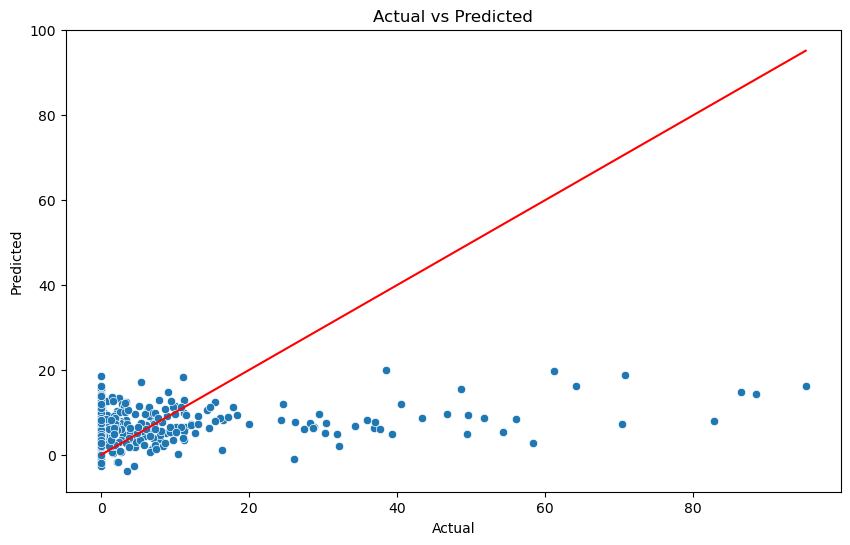

In [616]:
# Pipeline A = preproc1 + baseline

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
pipeline_a = Pipeline([('preprocessing', preproc1),
    ('regressor', LinearRegression())])
pipeline_a.fit(X_train, Y_train)

predictionA = pipeline_a.predict(X_train)
MSE = mean_squared_error(Y_train, predictionA)
R2_score = r2_score(Y_train, predictionA)
print(f'MSE =  {MSE} ')
print(f'r2 =  {R2_score} ')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_train, y=predictionA)
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], color='red', linestyle='-')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [617]:
# Pipeline B = preproc2 + baseline
pipeline_b = Pipeline([('preprocessing', preproc2),
    ('regressor', LinearRegression())])
pipeline_b.fit(X_train, Y_train)
predictionB = pipeline_b.predict(X_train)
MSE = mean_squared_error(Y_train, predictionB)
R2_score = r2_score(Y_train, predictionB)
print(f'MSE =  {MSE} ')
print(f'r2 =  {R2_score} ')

MSE =  195.52261435673304 
r2 =  0.07619118603268282 


MSE =  34.384043391495155 
r2 =  0.837541644738119 


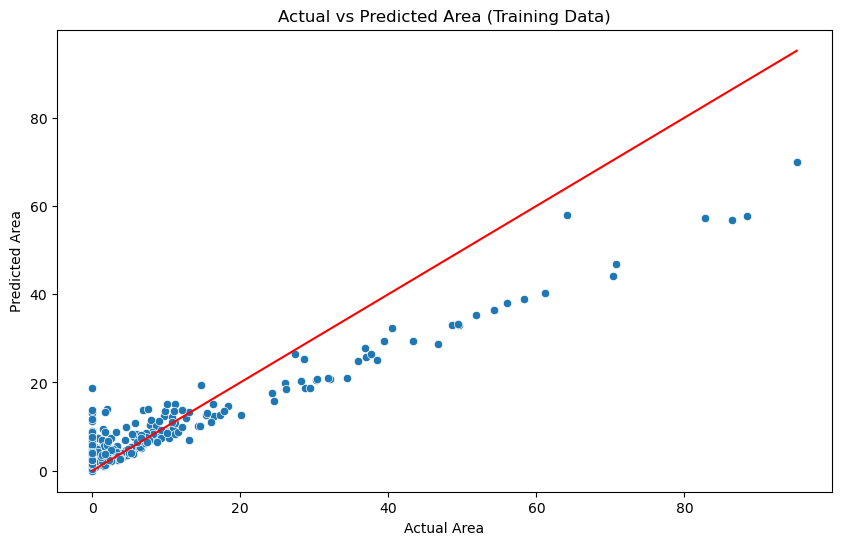

In [618]:
# Pipeline C = preproc1 + advanced model

pipeline_c= Pipeline([('preprocessing', preproc1),
    ('regressor', RandomForestRegressor())])

pipeline_c.fit(X_train, Y_train)

pipelineC = pipeline_c.predict(X_train)
MSE = mean_squared_error(Y_train, pipelineC)
R2_score = r2_score(Y_train, pipelineC)
print(f'MSE =  {MSE} ')
print(f'r2 =  {R2_score} ')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_train, y=pipelineC)
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], color='red', linestyle='-')
plt.title('Actual vs Predicted Area (Training Data)')
plt.xlabel('Actual Area')
plt.ylabel('Predicted Area')
plt.show()

MSE =  34.87670818378602 
r2 =  0.8352138931430052 


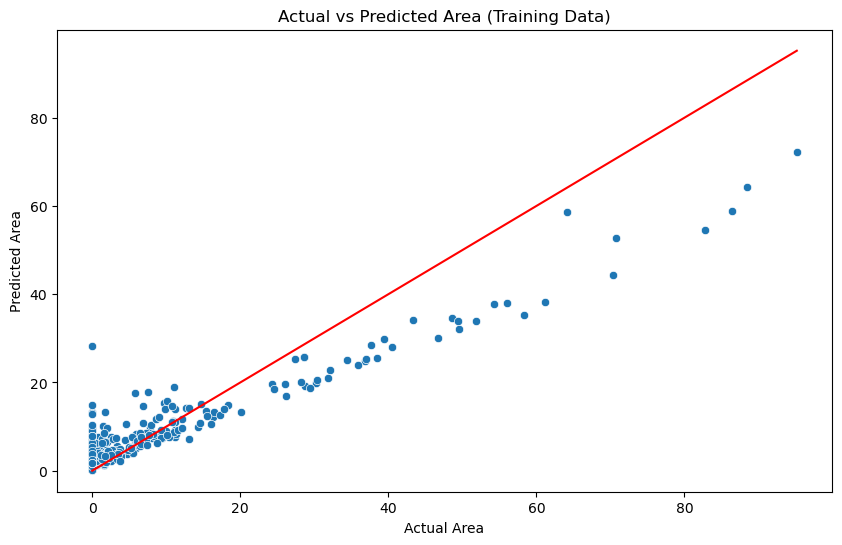

In [619]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline([('preprocessing', preproc2),
    ('regressor', RandomForestRegressor())])

pipeline_d.fit(X_train, Y_train)

pipelineD = pipeline_d.predict(X_train)
MSE = mean_squared_error(Y_train, pipelineD)
R2_score = r2_score(Y_train, pipelineD)
print(f'MSE =  {MSE} ')
print(f'r2 =  {R2_score} ')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_train, y=pipelineD)
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], color='red', linestyle='-')
plt.title('Actual vs Predicted Area (Training Data)')
plt.xlabel('Actual Area')
plt.ylabel('Predicted Area')
plt.show()

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [620]:


param_linear_regression = {'regressor__fit_intercept': [True, False], }

grid_cv_a = GridSearchCV(pipeline_a, param_linear_regression, cv=5, scoring='neg_mean_squared_error')
grid_cv_a.fit(X_train, Y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [621]:

grid_cv_b = GridSearchCV(pipeline_b, param_linear_regression, cv=5, scoring='neg_mean_squared_error')
grid_cv_b.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('non_linear',
                                                                                          PowerTransformer())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [622]:
param_forest_regressor = {'regressor__n_estimators': [50, 100, 200, 300] }
grid_cv_c = GridSearchCV(pipeline_c, param_forest_regressor, cv=5, scoring='neg_mean_squared_error')
grid_cv_c.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__n_estimators': [50, 100, 200, 300]},
             scoring='neg_mean_squared_error')

In [623]:

grid_cv_d = GridSearchCV(pipeline_d, param_forest_regressor, cv=5, scoring='neg_mean_squared_error')
grid_cv_d.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('non_linear',
                                                                                          PowerTransformer())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__n_estimators': [50, 100, 200, 300]},
             scoring='neg_mean_squared_error')

In [624]:
res = grid_cv_a.cv_results_
res = pd.DataFrame(res)
print(res)
print(grid_cv_a.best_params_)

grid_cv_a.best_estimator_

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.016607      0.002903         0.006589        0.000475   
1       0.015371      0.001491         0.005828        0.000407   

  param_regressor__fit_intercept                               params  \
0                           True   {'regressor__fit_intercept': True}   
1                          False  {'regressor__fit_intercept': False}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0        -250.717763        -250.266268        -235.749537        -194.255048   
1        -250.717763        -250.266268        -235.749537        -194.255048   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0        -355.995995      -257.396922       53.427971                2  
1        -355.792900      -257.356303       53.353019                1  
{'regressor__fit_intercept': False}


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression(fit_intercept=False))])

In [625]:
import joblib

res = grid_cv_b.cv_results_
res = pd.DataFrame(res)
print(res)
print(grid_cv_b.best_params_)



   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.024592      0.005889         0.006017        0.001090   
1       0.024400      0.004964         0.005210        0.000754   

  param_regressor__fit_intercept                               params  \
0                           True   {'regressor__fit_intercept': True}   
1                          False  {'regressor__fit_intercept': False}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0         -253.66919        -249.431064        -232.034548        -191.240041   
1         -253.66919        -249.431064        -232.034548        -191.240041   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0        -279.087666      -241.092502       29.115809                1  
1        -279.146174      -241.104203       29.131084                2  
{'regressor__fit_intercept': True}


In [626]:
res = grid_cv_c.cv_results_
res = pd.DataFrame(res)
print(res)
print(grid_cv_c.best_params_)

best_model = grid_cv_c.best_estimator_

joblib.dump(best_model, 'best_model.pkl')

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.140115      0.020693         0.007002        0.001545   
1       0.242746      0.015241         0.009019        0.002122   
2       0.463115      0.012689         0.011390        0.001349   
3       0.709365      0.018629         0.013411        0.000798   

  param_regressor__n_estimators                            params  \
0                            50   {'regressor__n_estimators': 50}   
1                           100  {'regressor__n_estimators': 100}   
2                           200  {'regressor__n_estimators': 200}   
3                           300  {'regressor__n_estimators': 300}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0        -276.473905        -291.588445        -229.749628        -210.002296   
1        -284.648560        -272.959633        -250.200736        -205.471486   
2        -286.870920        -285.344158        -245.413860        -199.9268

['best_model.pkl']

In [627]:
res = grid_cv_d.cv_results_
res = pd.DataFrame(res)
print(res)
print(grid_cv_d.best_params_)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.137404      0.005356         0.007400        0.000491   
1       0.254315      0.015995         0.008816        0.000752   
2       0.480398      0.012579         0.012193        0.001465   
3       0.682696      0.018386         0.014625        0.000989   

  param_regressor__n_estimators                            params  \
0                            50   {'regressor__n_estimators': 50}   
1                           100  {'regressor__n_estimators': 100}   
2                           200  {'regressor__n_estimators': 200}   
3                           300  {'regressor__n_estimators': 300}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0        -269.169468        -289.424240        -260.604314        -188.392428   
1        -292.103480        -265.718150        -260.039724        -202.490160   
2        -275.655489        -279.996439        -257.710041        -202.3435

# Evaluate

+ Which model has the best performance?

given the results Model C is the best based on a lower mean test score and a high r2 score compared to the other models
with the following parameters:
 {'regressor__n_estimators': 100}   

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

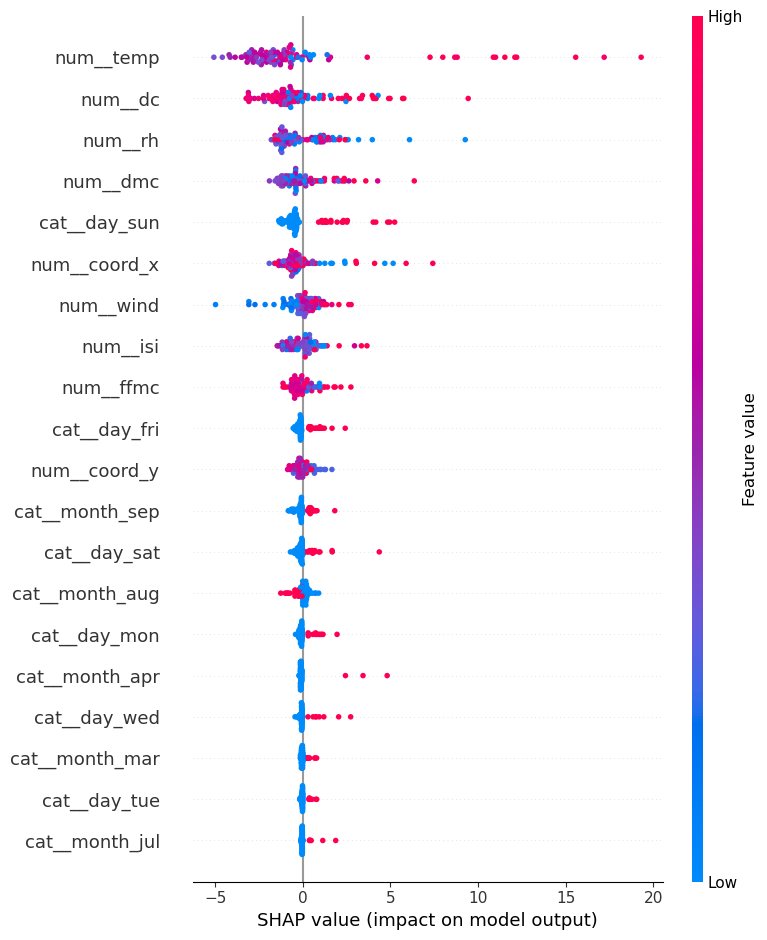

           Feature  Mean Absolute SHAP Value
6        num__temp                  2.999193
4          num__dc                  1.684216
7          num__rh                  1.259939
3         num__dmc                  0.998613
24    cat__day_sun                  0.985070
0     num__coord_x                  0.935480
8        num__wind                  0.692484
5         num__isi                  0.671900
2        num__ffmc                  0.501472
21    cat__day_fri                  0.328834
1     num__coord_y                  0.318533
20  cat__month_sep                  0.297317
23    cat__day_sat                  0.293476
11  cat__month_aug                  0.236141
22    cat__day_mon                  0.216889
10  cat__month_apr                  0.212368
27    cat__day_wed                  0.183427
16  cat__month_mar                  0.087432
26    cat__day_tue                  0.086478
14  cat__month_jul                  0.084241
25    cat__day_thu                  0.058567
12  cat__m

In [628]:
import shap
import numpy as np
best_model = joblib.load('best_model.pkl')
X_test_transformed = best_model.named_steps['preprocessing'].transform(X_test)
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

explainer = shap.Explainer(best_model.named_steps['regressor'], X_test_transformed, feature_names=feature_names)

shap_values_all = explainer(X_test_transformed, check_additivity=False)

shap.summary_plot(shap_values_all, X_test_transformed, feature_names=feature_names)

mean_abs_shap_values = np.mean(np.abs(shap_values_all.values), axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Absolute SHAP Value': mean_abs_shap_values
})
sorted_feature_importance_df = feature_importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

print(sorted_feature_importance_df)




Answer 

Most Important Features: `num__temp`, `num__dc`, `num__rh`, and `num__dmc` are the most important features based on SHAP values and feature importances.

Least Important Features: `cat__month_nov`, `cat__month_may`, and `num__rain` are the least important features based on SHAP values and feature importances.

Features to Remove and Why: Remove `cat__month_nov`, `cat__month_may`, `num__rain`, and `cat__month_dec` because they contribute minimally to the model's predictive power.

Testing Feature Removal: Retrain the model without these features and compare performance metrics (MSE and R²) to the original model to determine if the removed features impact performance.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.